In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from nipy.modalities.fmri.hemodynamic_models import spm_hrf
import numpy as np
import pandas as pd
import nibabel as nib
import os
import json

## BIDS files

In [11]:
# make the directories for the bids dataset
bids_out_dir = './bids/sub-test01/func'

os.makedirs(bids_out_dir, exist_ok=True)
events_file = os.path.join(bids_out_dir, 'sub-test01_task-whodis_events.tsv')
bold_file = os.path.join(bids_out_dir, 'sub-test01_task-whodis_bold.nii.gz')

# make dataset description
data_descr = {"BIDSVersion": "1.0.0rc4", "Name": "Chicken Nugger"}
with open('./bids/dataset_description.json', 'w') as dd:
    json.dump(data_descr, dd)
    
# make task json file
img_metadata = {"RepetitionTime": 2.0, "TaskName": "whodis"}
img_metadata_file = os.path.join(bids_out_dir, 'sub-test01_task-whodis_bold.json')
with open(img_metadata_file, 'w') as im:
    json.dump(img_metadata, im)

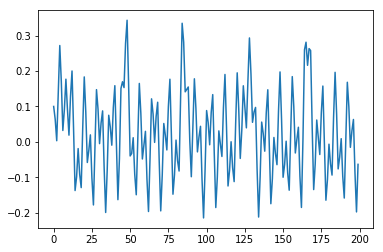

In [12]:
tr = 2 # repetition time 2 seconds
tp = 200 # time_points
ix = np.arange(tp)

task_onsets = np.zeros(tp) # create voxel timeseries
task_onsets[0::40] = 1 # add activations at every 40 time points

# create voxel timeseries

# signal
signal = np.convolve(task_onsets, spm_hrf(tr, oversampling=2))[0:len(task_onsets)]

# csf
csf = np.cos(2*np.pi*ix*(50/tp)) * 0.1

# white matter
wm = np.sin(2*np.pi*ix*(22/tp)) * 0.1

# voxel time series (signal and noise)
voxel_ts = signal + csf + wm

img_data = np.array([[[voxel_ts, voxel_ts]]]) # a 4d matrix with 2 identical timeseries
img = nib.Nifti1Image(img_data, np.eye(4)) # make a nifti image
img.to_filename(bold_file) # save the nifti image
plt.plot(voxel_ts)

In [13]:
# create event tsv
onsets = np.multiply(np.where(task_onsets == 1), tr).reshape(5)
durations = [1] * onsets.size
trial_types = ['testCond'] * onsets.size

events_df = pd.DataFrame.from_dict({'onset': onsets, 'duration': durations, 'trial_type': trial_types})
# reorder columns
events_df = events_df[['onset', 'duration', 'trial_type']]
# save the events_df to file
events_df.to_csv(events_file, index=False, sep='\t')

## Derivatives (fmriprep files)

In [16]:
deriv_out_dir = './bids/derivatives/fmriprep/sub-test01/func'
os.makedirs(deriv_out_dir, exist_ok=True)

confounds_file = os.path.join(deriv_out_dir, 'sub-test01_task-whodis_bold_confounds.tsv')
preproc_file = os.path.join(deriv_out_dir, 'sub-test01_task-whodis_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
brainmask_file = os.path.join(deriv_out_dir, 'sub-test01_task-whodis_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz')
# save the confounds
confounds_df = pd.DataFrame({'WhiteMatter': wm, 'CSF': csf})
confounds_df.to_csv(confounds_file, index=False, sep='\t')

# save the preproc (same as image in the bids directory)
img.to_filename(preproc_file)

# make the brainmask
bm_data = np.array([[[1, 1]]], dtype=np.int16)
bm_img = nib.Nifti1Image(bm_data, np.eye(4)) # make a nifti image
bm_img.to_filename(brainmask_file) # save the nifti image

## Atlas Files

In [18]:
atlas_file = 'atlas.nii.gz'
atlas_lut_file = 'atlas_lut.tsv'

# make atlas nifti
atlas_data = np.array([[[1, 2]]], dtype=np.int16)
atlas_img = nib.Nifti1Image(atlas_data, np.eye(4)) # make a nifti image
atlas_img.to_filename(atlas_file) # save the nifti image

# make atlas lookup table
atlas_lut_df = pd.DataFrame({'index': [1, 2], 'regions': ['waffle', 'fries']})
atlas_lut_df.to_csv(atlas_lut_file, index=False, sep='\t')